In [1]:
import random

In [2]:
import argparse, os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import cucim.skimage.metrics as met

import utils
import data.HCP_dataset_h5_arb as HCP_dataset

number of common Subjects  171


7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 145

In [7]:
parser = argparse.ArgumentParser(description="DTI_ARB")
parser.add_argument("--block_size", type=tuple, default=(16,16,4),
                    help="Block Size")
parser.add_argument("--test_block_size", type=tuple, default=(16,16,4),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
parser.add_argument("--scale", type=tuple, default=(2,1.5,1),
                    help="test_size")
parser.add_argument("--ret_points", type=bool, default=False,
                    help="return box point of crops")
parser.add_argument("--thres", type=float, default=0.65,
                    help="threshold for blk emptiness")
parser.add_argument("--test_thres", type=float, default=0.65,
                    help="threshold for blk emptiness")
args = list(parser.parse_known_args())[0]
args.preload = True
args.ret_points = True
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.scale = [1.2,1.2,1.2]
args.thres = 0.2
args.stride = (1,1,1)
print(args)

Namespace(batch_size=4, block_size=(16, 16, 4), crop_depth=15, debug=None, dir='/storage', preload=True, ret_points=True, scale=[1.2, 1.2, 1.2], sort=True, stride=(1, 1, 1), test_block_size=(16, 16, 4), test_thres=0.65, thres=0.2)


In [8]:
ids = utils.get_ids()
ids.sort()
ids = ids[:1]
dataset_hcp = HCP_dataset
dataset_hcp.load_data(args.dir,ids)

[1.2, 1.2, 1.2]


['100610']

In [9]:
testing_dataset = dataset_hcp.hcp_data_test_recon(args,ids,debug = True)

NameError: name 'adc' is not defined

In [10]:
import loader
lr,hr = loader.load_data('/storage',ids)

In [17]:
print(hr['100610']['ADC'].max(),hr['100610']['ADC'].min())
print(hr['100610']['ADC'].max(),lr['100610']['ADC'].min())

0.0

In [ ]:
len(testing_dataset)

In [ ]:
x = testing_dataset[0]
for i in range(len(x)):
    print(i,x[i].shape)

In [ ]:
x[5]

In [ ]:
vol_size = [145, 174, 145]
vol_size = [int(vol_size[i] * x[5][i]) for i in range(3)]
vol_size.append(7)

In [ ]:
vol_size

### Vol_Reconstruction

In [14]:
def recon(blks,lr,vol_size,ret_patch = False):
    num_blk = blks.shape[0]
    patch_dict = {}
    vol = np.zeros(vol_size)
    for i in range(num_blk):
#         print(vol[lr[i][0]:lr[i][1]+1,lr[i][2]:lr[i][3]+1,lr[i][4]:lr[i][5]+1,...].shape)
        vol[lr[i][0]:lr[i][1]+1,lr[i][2]:lr[i][3]+1,lr[i][4]:lr[i][5]+1,...] = blks[i,...]
        if(ret_patch):
            img_pnt = lr[i]
            y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
            sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
            if(sliceee not in patch_dict.keys()):
                patch_dict[sliceee] = [(x,y,w,d)]
            else:
                patch_dict[sliceee].append((x,y,w,d))
            
    return vol,patch_dict

In [16]:
res,patches = recon(x[6],x[4],vol_size=vol_size,ret_patch = True)

In [29]:
res.shape,hr['100610']['vol0'].shape

((217, 278, 232, 7), (173, 207, 171, 7))

In [38]:
hr_res_scale = [round(res.shape[i] / hr['100610']['vol0'].shape[i],3) for i in range(3)]

In [39]:
hr_res_scale

[1.254, 1.343, 1.357]

In [44]:
offset = 81
sl = int(hr_res_scale[1] * offset)

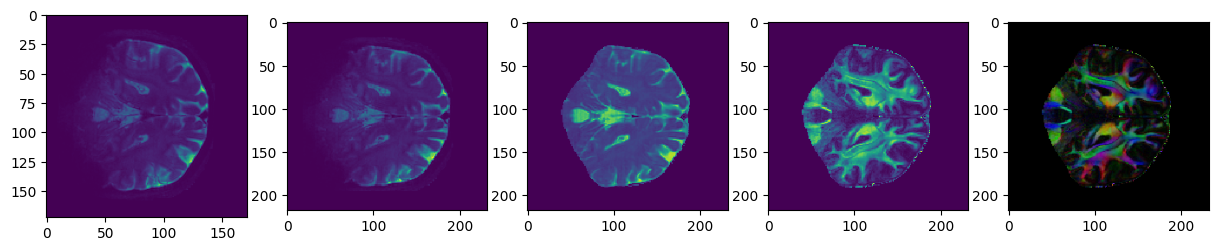

In [49]:
fig, ax = plt.subplots(1,5)
# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*5)
 
# set width of each subplot as 8
fig.set_figwidth(15)
ax[0].imshow(torch.from_numpy(hr['100610']['vol0'])[:,offset,:,0])
ax[1].imshow(res[:,sl,:,0])
ax[2].imshow(x[1][:,sl,:])
ax[3].imshow(x[2][:,sl,:])
ax[4].imshow(x[3][:,sl,:])
# ax[2].imshow(torch.from_numpy(hr['100610']['vol0'])[:,81,:,0]-res[:,81,:,0])

In [51]:
for i in range(3):
    print(x[i+1].min(),x[i+1].max(),x[i+1].shape)

tensor(0., dtype=torch.float64) tensor(0.0823, dtype=torch.float64) torch.Size([217, 278, 232])
tensor(0., dtype=torch.float64) tensor(1.0000, dtype=torch.float64) torch.Size([217, 278, 232])
tensor(0., dtype=torch.float64) tensor(0.9998, dtype=torch.float64) torch.Size([217, 278, 232, 3])


In [25]:
def resize(data,ret_pnt = True):
    if(ret_pnt == False):
        x,y = [],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
        return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))
    else:
        x,y,z,vols = [],[],[],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
            z.append({'lr':data[i][4],'hr':data[i][5]})
            vols.append(data[i][6])
        lr = torch.from_numpy(np.stack(x))
        pred = torch.from_numpy(np.stack(y))
        return lr,pred,z,vols

In [26]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=1, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

NameError: name 'training_dataset' is not defined

In [21]:
len(training_data_loader)

5

In [22]:
temp = next(iter(training_data_loader))

IndexError: tuple index out of range

In [31]:
temp[0].shape

torch.Size([8, 16, 16, 4, 7])

In [32]:
temp[1].shape

torch.Size([8, 22, 29, 6, 5])

In [33]:
temp[2]

[{'lr': array([79, 96, 64, 87, 75, 80]),
  'hr': array([ 92, 113,  77, 105,  88,  93])},
 {'lr': array([46, 63, 45, 68, 81, 86]),
  'hr': array([ 55,  76,  55,  83,  96, 101])},
 {'lr': array([ 79,  96,  94, 117,  71,  76]),
  'hr': array([ 93, 114, 110, 138,  83,  88])},
 {'lr': array([ 94, 111,  95, 118,  39,  44]),
  'hr': array([110, 131, 112, 140,  44,  49])},
 {'lr': array([ 95, 112,  92, 115,  45,  50]),
  'hr': array([111, 132, 108, 136,  52,  57])},
 {'lr': array([ 17,  34,  78, 101,  37,  42]),
  'hr': array([ 21,  42,  92, 120,  44,  49])},
 {'lr': array([ 63,  80, 124, 147,  53,  58]),
  'hr': array([ 74,  95, 143, 171,  62,  67])},
 {'lr': array([ 94, 111, 124, 147,  45,  50]),
  'hr': array([110, 131, 142, 170,  52,  57])}]

In [34]:
temp[3]

['102311',
 '105923',
 '100610',
 '102311',
 '105923',
 '102816',
 '105923',
 '104416']

In [35]:
temp[3]

['102311',
 '105923',
 '100610',
 '102311',
 '105923',
 '102816',
 '105923',
 '104416']

In [36]:
l=8
temp = next(iter(training_data_loader))

In [37]:
len(temp)

4

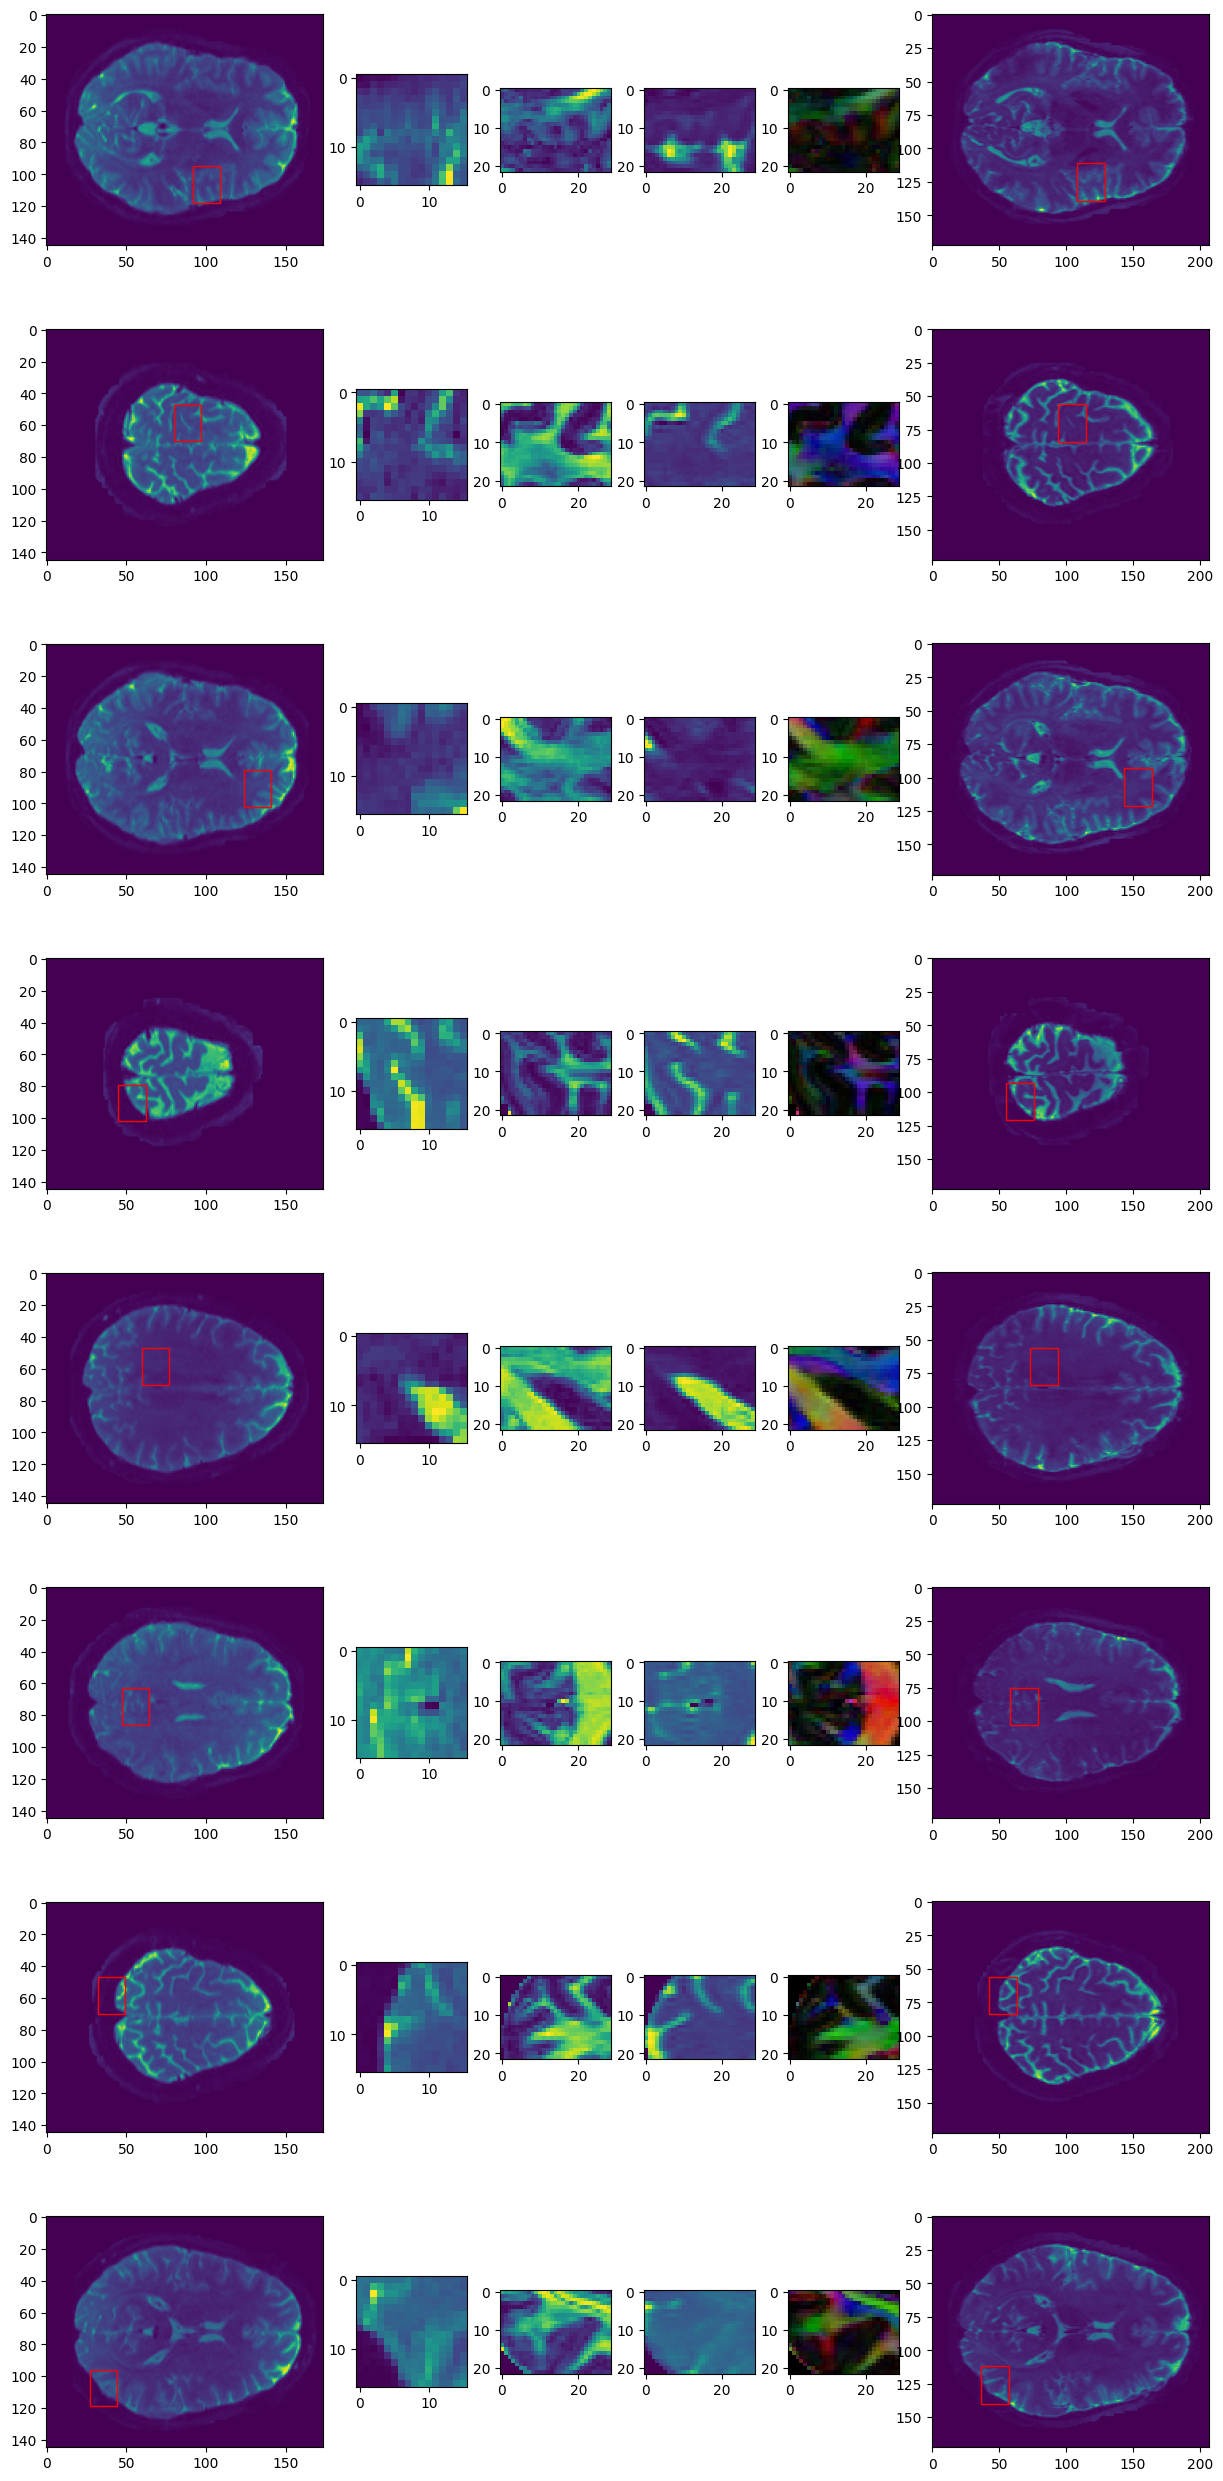

In [38]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(l,6,gridspec_kw={'width_ratios': [2.5, 1,1,1,1,2.5]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)

for i in range(l):
    
    data_7t= loaded_gt[temp[3][i]]['vol0']
    data_3t= loaded[temp[3][i]]['vol0']
    img_pnt = temp[2][i]['lr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,sliceee,0])
    ax[i][1].imshow(temp[0][i,:,:,0,0])
    ax[i][2].imshow(temp[1][i,:,:,0,0])
    ax[i][3].imshow(temp[1][i,:,:,0,1])
    ax[i][4].imshow(temp[1][i,:,:,0,2:])
#     ax[i][5].imshow(temp[0][i,:,:,0,7])
    
    img_pnt = temp[2][i]['hr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ax[i][5].imshow(data_7t[:,:,sliceee,0])
    ax[i][5].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
plt.show()

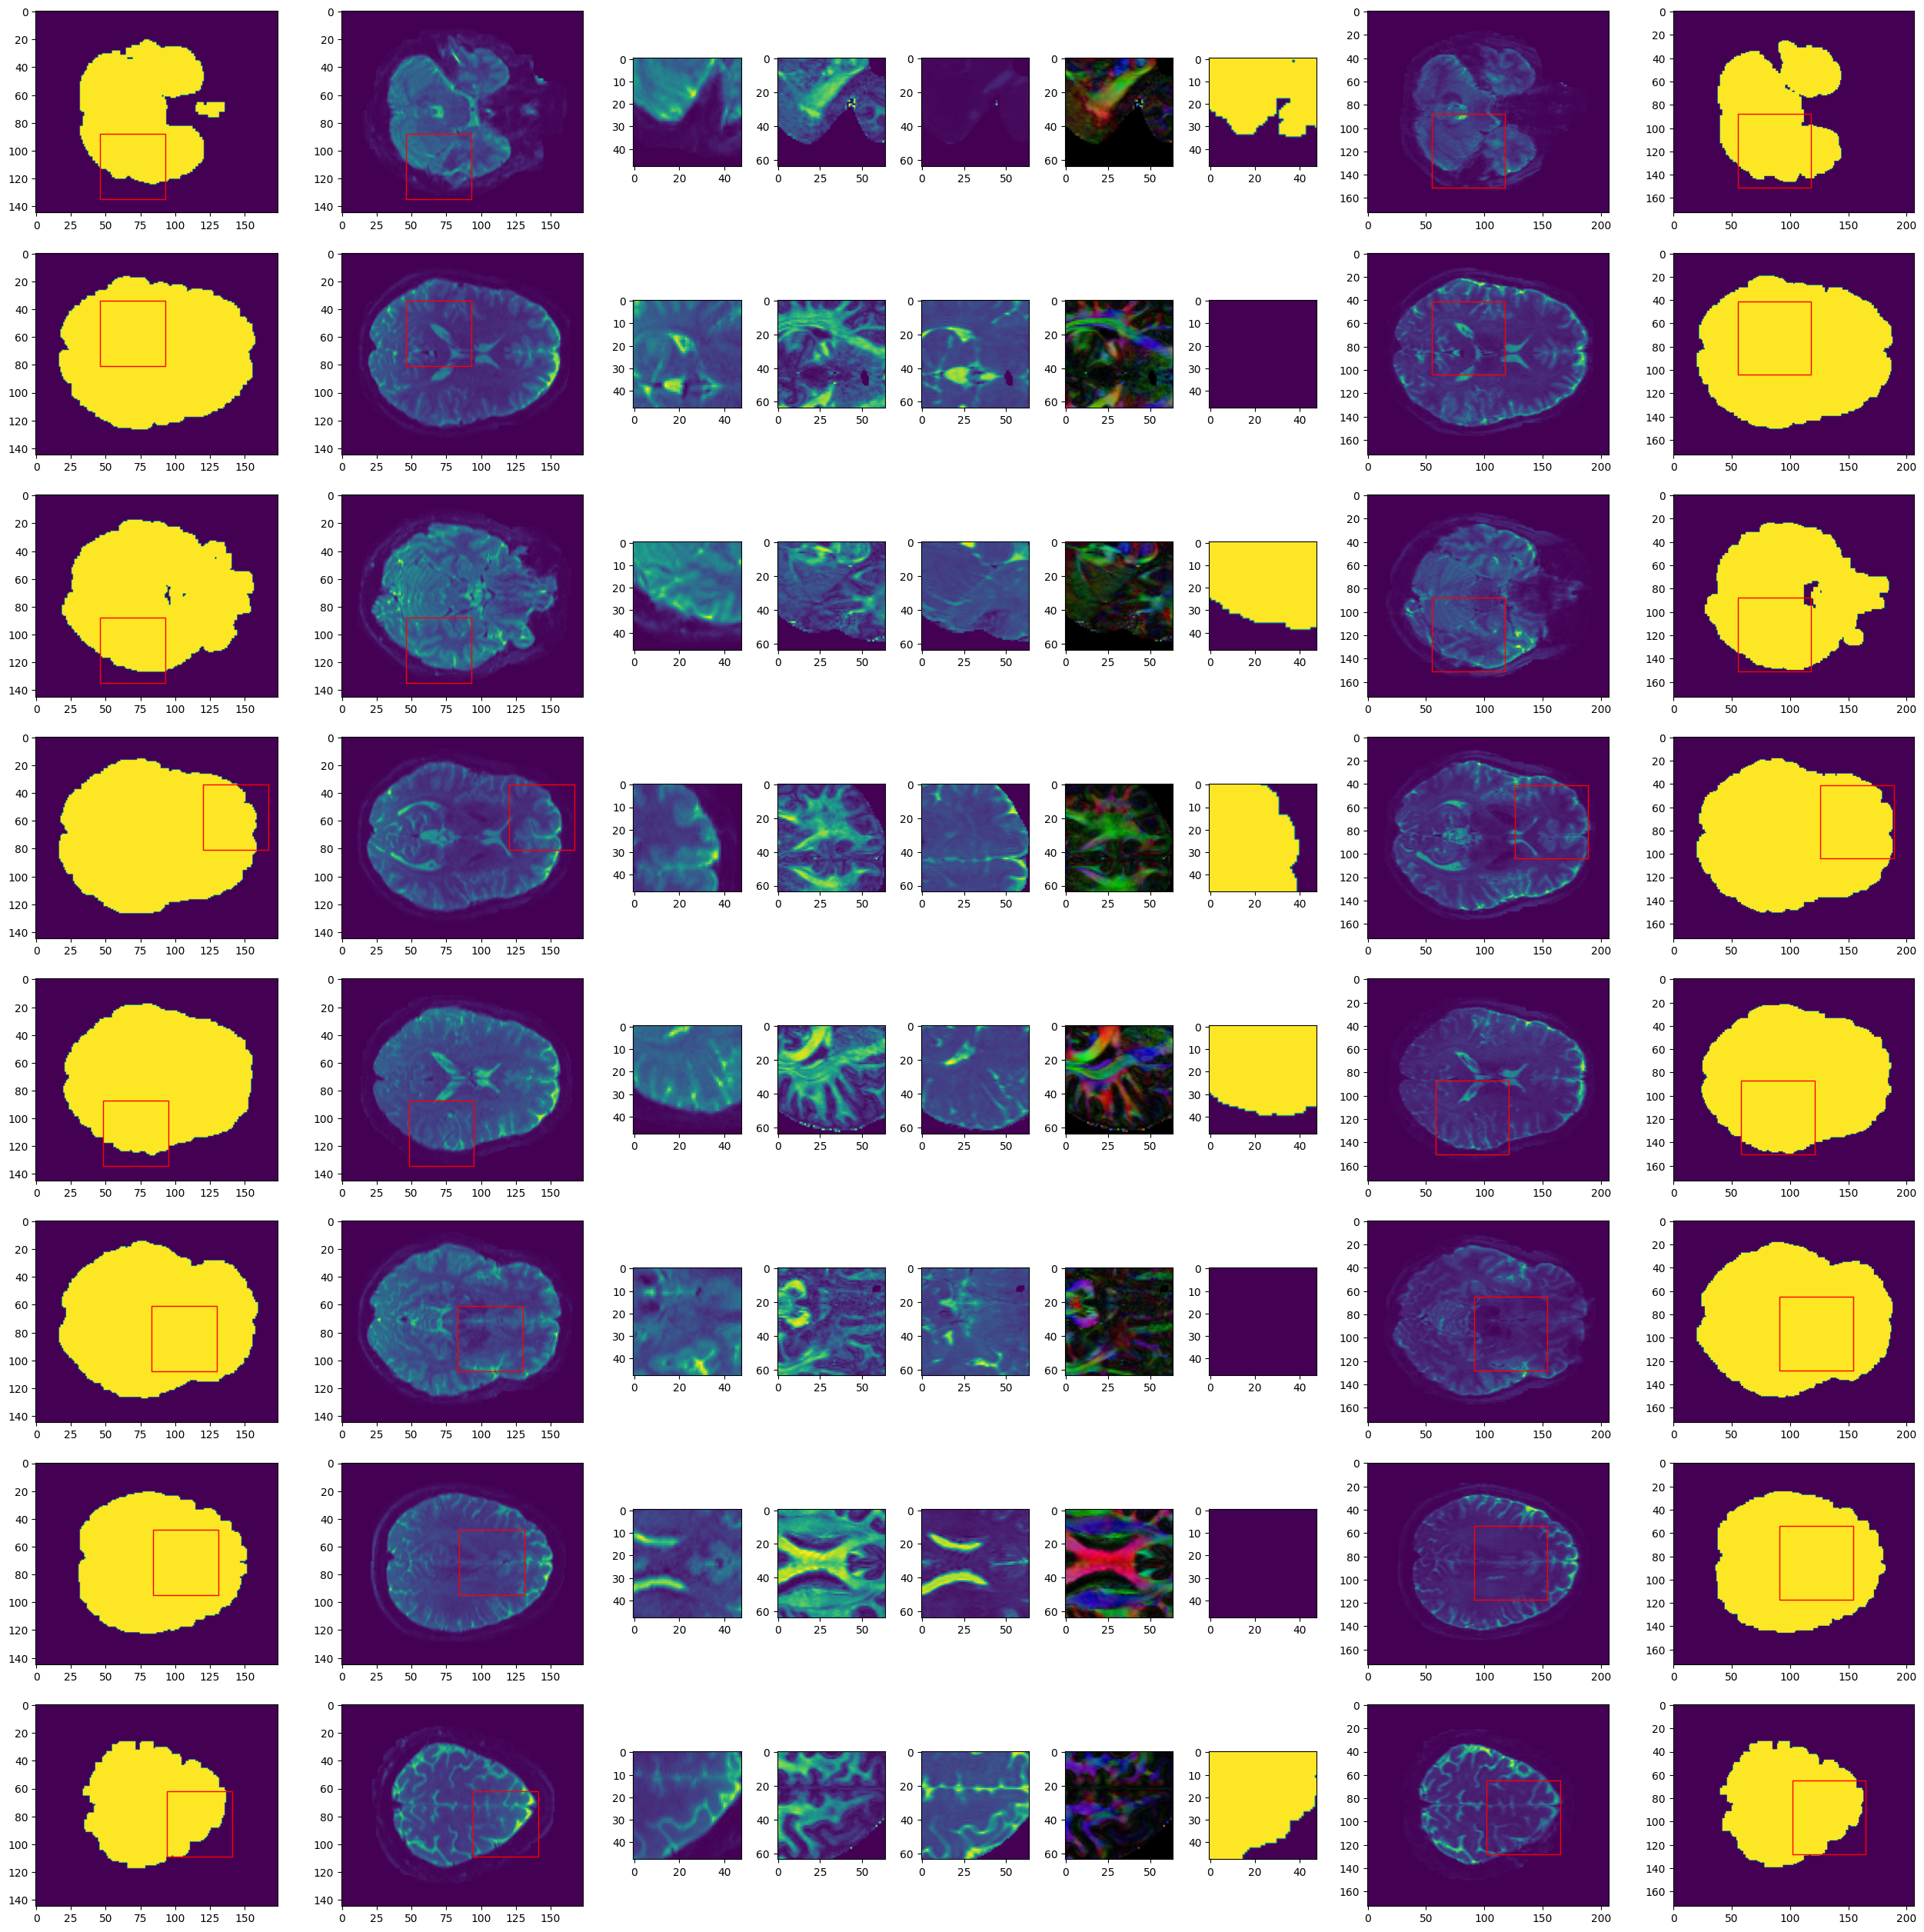

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(l,9,gridspec_kw={'width_ratios': [2.5,2.5, 1,1,1,1,1,2.5,2.5]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(4*l)

for i in range(l):
    
    data_7t= loaded_gt[temp[3][i]]['vol0']
    data_7t_mask= loaded_gt[temp[3][i]]['mask']
    data_3t_mask= loaded[temp[3][i]]['mask']
    data_3t= loaded[temp[3][i]]['vol0']
    img_pnt = temp[2][i]['lr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t_mask[:,:,sliceee])
    
    ax[i][1].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][1].imshow(data_3t[:,:,sliceee,0])
    ax[i][2].imshow(temp[0][i,:,:,0,0])
    ax[i][3].imshow(temp[1][i,:,:,0,0])
    ax[i][4].imshow(temp[1][i,:,:,0,1])
    ax[i][5].imshow(temp[1][i,:,:,0,2:])
    ax[i][6].imshow(temp[0][i,:,:,0,7])
    
    img_pnt = temp[2][i]['hr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ax[i][7].imshow(data_7t[:,:,sliceee,0])
    ax[i][7].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][8].imshow(data_7t_mask[:,:,sliceee])
    ax[i][8].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
plt.show()

In [ ]:
for i in limited_common:
    name = "/storage/HCP_3T/" + i + "/" + i + ".h5"
    if(not os.path.isfile(name) or True):
        print("Current ID",i)

        gtab = load_gtab(i,'3T')

        data_sitk = sitk.ReadImage(path['3T'][i]['data'])
        mask_sitk = sitk.ReadImage(path['3T'][i]['brain_mask'])
        hf = h5py.File(name, 'w')
        
        idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))

        idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]

        for j in range(1):
            sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
            ## picking one base bval volume randomly from the data
            sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]
            
            ## picking the bvals,bvecs and corresponding vols from the data 
            bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
            bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
            data6,mask6 = resampler(data_sitk,idx[j],sample)
            shape_file[i] = (data6.shape)
            hf.create_dataset('volumes'+ str(j), data=data6)
            hf.create_dataset('bvals'+ str(j), data=bvals6)
            hf.create_dataset('bvecs'+ str(j), data=bvecs6)

        hf.create_dataset('idx', data=idx)
        hf.create_dataset('cond', data=cond)
        hf.create_dataset('mask', data=mask6)

        hf.close()

        print(name,"Done")

        